Testing DM reading

In [2]:
import sys
illustrisPath = '/home/fdavilakurban/'
#basePath = '../../../TNG300-1/output/'
basePath='/media/fdavilakurban/0a842929-67de-4adc-b64c-8bc6d17a08b0/fdavilakurban/TNG300-1/output'
sys.path.append(illustrisPath)
import illustris_python as il
import numpy as np
import h5py

def pSplitRange(indrange, numProcs, curProc, inclusive=False):
    """ Divide work for embarassingly parallel problems. 
    Accept a 2-tuple of [start,end] indices and return a new range subset.
    If inclusive==True, then assume the range subset will be used e.g. as input to snapshotSubseet(),
    which unlike numpy convention is inclusive in the indices."""
    assert len(indrange) == 2 and indrange[1] > indrange[0]

    if numProcs == 1:
        if curProc != 0:
            raise Exception("Only a single processor but requested curProc>0.")
        return indrange

    # split array into numProcs segments, and return the curProc'th segment
    splitSize = int(np.floor( (indrange[1]-indrange[0]) / numProcs ))
    start = indrange[0] + curProc*splitSize
    end   = indrange[0] + (curProc+1)*splitSize

    # for last split, make sure it takes any leftovers
    if curProc == numProcs-1:
        end = indrange[1]

    if inclusive and curProc < numProcs-1:
        # not for last split/final index, because this should be e.g. NumPart[0]-1 already
        end -= 1

    return [start,end]


def loadSubset(simPath, snap, partType, fields, chunkNum=0, totNumChunks=1):
    """ Load part of a snapshot. """
    nTypes = 6
    ptNum = il.util.partTypeNum(partType)

    with h5py.File(il.snapshot.snapPath(simPath,snap),'r') as f:
        numPartTot = il.snapshot.getNumPart( dict(f['Header'].attrs.items()) )[ptNum]

    # define index range
    indRange_fullSnap = [0,numPartTot-1]
    indRange = pSplitRange(indRange_fullSnap, totNumChunks, chunkNum, inclusive=True)

    # load a contiguous chunk by making a subset specification in analogy to the group ordered loads
    subset = { 'offsetType'  : np.zeros(nTypes, dtype='int64'),
               'lenType'     : np.zeros(nTypes, dtype='int64') }

    subset['offsetType'][ptNum] = indRange[0]
    subset['lenType'][ptNum]    = indRange[1]-indRange[0]+1

    # add snap offsets (as required)
    with h5py.File(il.snapshot.offsetPath(simPath,snap),'r') as f:
        subset['snapOffsets'] = np.transpose(f['FileOffsets/SnapByType'][()])

    # load from disk
    r = il.snapshot.loadSubset(simPath, snap, partType, fields, subset=subset)

    return r


In [3]:
dm_pos = loadSubset(basePath,99,'dm',['Coordinates'],chunkNum=0,totNumChunks=500)


In [36]:
print(np.shape(dm_pos))
print(dm_pos[:10],dm_pos[:,0].min()/1000.,dm_pos[:,0].max()/1000.)
print(len(dm_pos))

(31249999, 3)
[[ 43963.513783    48729.94361318 147412.93383718]
 [ 45121.79733576  52011.07997299 146629.75949181]
 [ 45281.4262216   51961.24225002 147045.13996818]
 [ 43540.25397709  48702.86611596 147421.22186657]
 [ 43992.90977292  48825.0181372  147883.53934556]
 [ 43337.14147842  48159.53200192 147754.58676857]
 [ 43157.10640839  48629.66187516 148591.56945834]
 [ 44440.11602522  50269.7305107  146832.92629561]
 [ 43608.80209865  47535.50972156 147904.48870197]
 [ 43672.38835276  48215.90127395 147318.91605718]] 41.6927674379958 47.575347071417596
31249999


In [11]:
import random
a=dm_pos[np.random.randint(len(dm_pos),size=10)]
print(a)
b=np.append(a,dm_pos[np.random.randint(len(dm_pos),size=10)],axis=0)
print(b)

[[ 44174.56605046  48641.99503168 147546.4669353 ]
 [ 45265.74736138  49246.72871639 146513.53940275]
 [ 43698.53000567  48548.71665924 147950.11422433]
 [ 43660.64011045  48247.22152622 147250.73844022]
 [ 43698.53000567  48548.71665924 147950.11422433]
 [ 44735.02564768  49273.84315787 148122.55821195]
 [ 43641.27465149  48726.11620212 147480.06721641]
 [ 44735.02564768  49273.84315787 148122.55821195]
 [ 44174.56605046  48641.99503168 147546.4669353 ]
 [ 44735.02564768  49273.84315787 148122.55821195]]
[[ 44174.56605046  48641.99503168 147546.4669353 ]
 [ 45265.74736138  49246.72871639 146513.53940275]
 [ 43698.53000567  48548.71665924 147950.11422433]
 [ 43660.64011045  48247.22152622 147250.73844022]
 [ 43698.53000567  48548.71665924 147950.11422433]
 [ 44735.02564768  49273.84315787 148122.55821195]
 [ 43641.27465149  48726.11620212 147480.06721641]
 [ 44735.02564768  49273.84315787 148122.55821195]
 [ 44174.56605046  48641.99503168 147546.4669353 ]
 [ 44735.02564768  49273.84315

In [16]:
import random
rows_id=random.sample(range(0, dm_pos.shape[1]-1), 1)
print(dm_pos.shape[1]-1)

2


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.hist2d(dm_pos[:,0], dm_pos[:,1], norm=mpl.colors.LogNorm(), bins=10)
plt.xlim([0,250000])
plt.ylim([0,250000])
plt.xlabel('x [ckpc/h]')
plt.ylabel('y [ckpc/h]')
plt.show()



TypeError: list indices must be integers or slices, not tuple

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
nSubLoads = 500
dilution = 10

dm_pos = loadSubset(basePath,99,'dm',['Coordinates'],chunkNum=0,totNumChunks=nSubLoads)
pos_diluted = dm_pos[np.random.randint(len(dm_pos),size=dilution)]

print(pos_diluted)

for i in range(1,nSubLoads):
    t1=time.time()
    dm_pos = loadSubset(basePath,99,'dm',['Coordinates'],chunkNum=i,totNumChunks=nSubLoads)
    np.append(pos_diluted,dm_pos[np.random.randint(len(dm_pos),size=dilution)],axis=0)
    print(i,time.time()-t1)




[[ 43093.7703659   49545.08452465 145908.96145057]
 [ 43153.90693694  49733.69532969 146221.1389998 ]
 [ 43696.8304858   48874.17331653 147299.80931143]
 [ 43624.12919718  48294.55410456 147812.17762396]
 [ 42798.57302243  47735.54534472 147656.25341867]
 [ 42808.76219837  48851.78724826 147472.0369311 ]
 [ 43842.38682287  49317.27748888 146653.208549  ]
 [ 44268.2881432   51526.05688689 147002.51451934]
 [ 43687.89556892  49240.45507242 147165.9361152 ]
 [ 42992.44219442  46988.34173348 147311.61727673]]
1 7.184078693389893
2 7.195653438568115
3 7.18194842338562
4 7.301148176193237
5 7.109551906585693
6 7.248615503311157
7 7.350453853607178
8 7.631943702697754


KeyboardInterrupt: 

In [1]:
"""
Luego de correr test_readDM.py
"""
import numpy as np

dm_pos = np.load('../data/dmpos_diluted.npz')['arr_0']
print(len(dm_pos))
print(dm_pos)

78124503
[[ 43210.89608264  48552.15848704 146726.45099896]
 [ 43524.58147492  49012.9670058  147509.80663535]
 [ 42433.41100788  48626.48368239 147621.70324177]
 ...
 [191551.42104719  28854.56062657  75533.95331376]
 [196566.1053309   78707.37781278  21669.76747768]
 [199778.83785045   6124.84132149 142705.08240587]]


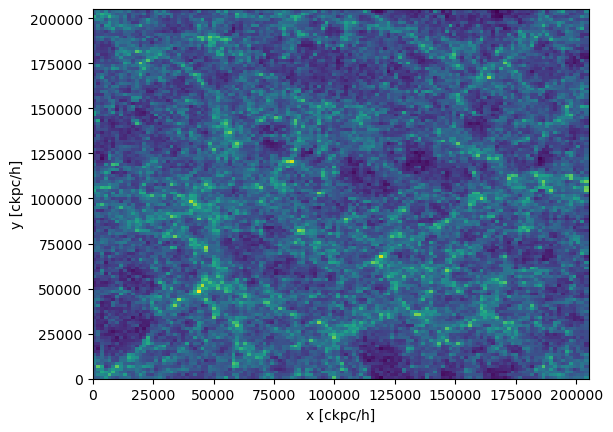

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.hist2d(dm_pos[:,0], dm_pos[:,1], norm=mpl.colors.LogNorm(), bins=128)

ax.set_xlim([0,205000])
ax.set_ylim([0,205000])
ax.set_xlabel('x [ckpc/h]')
ax.set_ylabel('y [ckpc/h]')

plt.show()